# Natural Language Processing and Information Extraction
## Deep learning - Practical Session

__Nov 7, 2025__

__Varvara Arzt__

Material of this lecture was created by Ádám Kovács and extended by Varvara Arzt

<a href="https://colab.research.google.com/github/tuw-nlp-ie/tuw-nlp-ie-2025WS/blob/main/lectures/05_Deep_learning_practical_lesson/deep_learning_practical_lesson_with_outputs.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



## Dataset Overview:
In this lecture, we are going to work with a classification dataset from [SemEval 2019 - Task 6](https://github.com/ZeyadZanaty/offenseval), which focuses on identifying and categorising Offensive Language in Social Media.

## About SemEval:
SemEval (Semantic Evaluation) is a series of international NLP research workshops where researchers compete to solve real-world language problems. Each year, organisers release datasets and challenges (called "shared tasks"), and teams from around the world build models to tackle these problems and compare their results. [Here](https://github.com/SemEval/SemEval2025/blob/main/tasks.md) you can find a list of shared tasks for SemEval-2025.

## Tools and Setup

### PyTorch

We'll be using [PyTorch](https://pytorch.org/docs/stable/index.html), an open-source library for building deep learning models that can run efficiently on GPUs. It's one of the most widely used frameworks for neural networks in both research and industry.

For your projects, you may want to explore **[HuggingFace](https://huggingface.co)** as well, a library that provides access to state-of-the-art pre-trained models and makes it much easier to work with modern transformer architectures.

### Prerequisites:

**Dataset:**
- SemEval 2019 - Task 6 dataset (code for downloading will be provided)

**Required Libraries:**

- PyTorch, pandas, scikit-learn, spacy
- transformers, accelerate, safetensors (for HuggingFace models)
- wandb (for experiment tracking)

### Installation

Run the following commands to install all required packages:
```python
# Install required packages
!pip install -q torch pandas scikit-learn spacy transformers accelerate safetensors wandb emoji==2.15.0

# Download spacy language model
!python -m spacy download en_core_web_sm
```

For OS-specific or CUDA-enabled PyTorch installation, consult the [PyTorch installation guide](https://pytorch.org/get-started/locally/).

> **Note:** We strongly recommend using [Google Colab](https://colab.research.google.com/) for this lab. It provides free GPU access and ensures a consistent environment for everyone, making it easier to reproduce results.

## What We'll Cover

In this lecture, we'll explore different approaches for text classification, progressing from simple to more advanced models:

1. **Feed Forward Neural Network (FNN)** with Bag-of-Words representation
2. **Multi-layer FNNs** for deeper feature learning
3. **Neural Networks with embedding layers** (+ max-pooling)
4. **Recurrent Neural Networks (RNNs)** and **LSTM networks** for sequential processing
5. **Transformer architecture (BERT)** for state-of-the-art performance

## 1. Setup and Installation

In [1]:
# Install required packages
!pip install -q torch pandas scikit-learn spacy transformers accelerate safetensors wandb
!pip3 install emoji==2.15.0
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 89.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import os
import time
import warnings
import urllib.request
from datetime import datetime

import emoji

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from transformers import (
    BertTokenizer,
    AutoTokenizer,
    BertForSequenceClassification,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
import wandb

# Configuration
warnings.filterwarnings('ignore')
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2. Data Loading and Preprocessing

In [3]:
# Download dataset
os.makedirs("./data", exist_ok=True)

dataset_url = "https://raw.githubusercontent.com/ZeyadZanaty/offenseval/master/datasets/training-v1/offenseval-training-v1.tsv"
dataset_path = "data/offenseval.tsv"

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(dataset_url, dataset_path)
    print("Dataset downloaded successfully")
else:
    print("Dataset already exists")

Dataset downloaded successfully


### Read in the dataset into a Pandas DataFrame
Load the dataset into a Pandas DataFrame using `pd.read_csv()`. The dataset is tab-separated and contains 5 columns:
`id`, `tweet`, `subtask_a`, `subtask_b`, `subtask_c`.

In [4]:
def read_dataset():
    train_data = pd.read_csv("./data/offenseval.tsv", sep="\t")
    return train_data

In [5]:
train_data_unprocessed = read_dataset()
train_data_unprocessed

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN
...,...,...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH
13238,27429,@USER Pussy,OFF,UNT,NaN


### Convert `subtask_a` Labels to Binary Format
The task is to classify tweets as either offensive (OFF) or not offensive (NOT). For machine learning algorithms, you will need integer labels instead of strings. Create a new column called `label` where:
- `NOT` → 0 (not offensive)
- `OFF` → 1 (offensive)

In [6]:
def transform(train_data):
    labels = {"NOT": 0, "OFF": 1}

    train_data["label"] = [labels[item] for item in train_data.subtask_a]
    train_data["tweet"] = train_data["tweet"].str.replace("@USER", "")

    return train_data

In [7]:
train_data = transform(train_data_unprocessed)
train_data

,id,tweet,subtask_a,subtask_b,subtask_c,label
0,86426,She should ask a few native Americans what th...,OFF,UNT,NaN,1
1,90194,Go home you’re drunk!!! #MAGA #Trump2020 👊🇺...,OFF,TIN,IND,1
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,0
3,62688,"Someone should'veTaken"" this piece of shit to...",OFF,UNT,NaN,1
4,43605,Obama wanted liberals &amp; illegals to move...,NOT,NaN,NaN,0
...,...,...,...,...,...,...
13235,95338,Sometimes I get strong vibes from people and ...,OFF,TIN,IND,1
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN,0
13237,82921,And why report this garbage. We don't give a...,OFF,TIN,OTH,1
13238,27429,Pussy,OFF,UNT,NaN,1


In [8]:
train_data.groupby("subtask_a").size()

,0
subtask_a,
NOT,8840
OFF,4400


### Split the dataset into a train and a validation dataset
Use the random seed for splitting. You should split the dataset into 70% training data and 30% validation data

In [9]:
def split_data(train_data, random_seed):
    tr_data, val_data = train_test_split(train_data, test_size=0.3, random_state=SEED)
    return tr_data, val_data

In [10]:
tr_data, val_data = split_data(train_data, SEED)

## 3. Text Preprocessing with CountVectorizer

We'll use [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) from scikit-learn to convert text into numerical features. This tool will:

- Tokenize, lowercase the text
- Filter out stopwords
- Convert the text into one-hot encoded vectors
- Select the _n_-best features

We fit CountVectorizer using _3000_ features (vocabulary size)

We will also _lemmatize_ texts using the _spaCy_ package and its lemmatizer. Check the [docs](https://spacy.io/models/en) for more.

CountVectorizer transforms text into a Bag-of-Words representation by counting how many times each word appears in a document. This creates a document-term matrix where each row is a document and each column is a word from the vocabulary.

![Bag-of-Words visualization](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*3IACMnNpwVlCl8kSTJocPA.png)

In [11]:
# Load spaCy model (disable unused components for speed)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

class SpacyLemmaTokenizer:
    """Custom tokenizer that lemmatizes words using spaCy."""
    def __init__(self):
        self.nlp = nlp

    def __call__(self, doc):
        return [token.lemma_ for token in self.nlp(doc)]


def prepare_vectorizer(tr_data):
    """Initialize and fit CountVectorizer on training data."""
    vectorizer = CountVectorizer(
        max_features=3000,
        tokenizer=SpacyLemmaTokenizer(),
        stop_words="english"
    )

    word_to_ix = vectorizer.fit(tr_data.tweet)

    return word_to_ix

In [12]:
# Fit vectorizer on training data
word_to_ix = prepare_vectorizer(tr_data)
VOCAB_SIZE = len(word_to_ix.vocabulary_)
assert VOCAB_SIZE == 3000

**Example: Lemmatization with spaCy**

In [13]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
sentence = "the kids are running happily towards the cars👍✅"
doc = nlp(sentence)

print("Original:", [token.text for token in doc])
print("Lemmatized:", [token.lemma_ for token in doc])

Original: ['the', 'kids', 'are', 'running', 'happily', 'towards', 'the', 'cars', '👍', '✅']
Lemmatized: ['the', 'kid', 'be', 'run', 'happily', 'towards', 'the', 'car', '👍', '✅']


**View top 10 most frequent words in our dataset after preprocessing**

In [14]:
# Transform training data to Bag-of-Words representation
X = word_to_ix.transform(tr_data.tweet)

# Top 10 words
top_10 = sorted([(word, X.sum(axis=0).A1[idx]) for word, idx in word_to_ix.vocabulary_.items()],
                key=lambda x: x[1], reverse=True)[:10]

print("Top 10 words:", top_10)

Top 10 words: [('.', np.int64(10031)), (' ', np.int64(7780)), ('#', np.int64(3685)), ('!', np.int64(3505)), ('I', np.int64(3070)), ('  ', np.int64(2354)), ('?', np.int64(2134)), ('"', np.int64(2079)), ('url', np.int64(1421)), ('liberal', np.int64(1154))]


**Example: Transform a new sentence to a Bag-of-Words representation**

In [15]:
example = word_to_ix.transform(["he loves science👍✅"]).toarray()
inv_vocab = {i: w for w, i in word_to_ix.vocabulary_.items()}
print(f"Bag-of-words vector: {example}")
print(f"Vector shape: {example.shape}")
print(f"Non-zero positions: {example.nonzero()}")
print(f"Tokens: {[inv_vocab[i] for i in example.nonzero()[1]]}")

Bag-of-words vector: [[0 0 0 ... 0 0 0]]
Vector shape: (1, 3000)
Non-zero positions: (array([0, 0, 0, 0]), array([1606, 2257, 2894, 2931]))
Tokens: ['love', 'science', '✅', '👍']


## 4. Prepare the DataLoader for Batch Processing

The `prepare_dataloader()` function converts our text data into PyTorch tensors:

1. **Transform tweets** into one-hot encoded vectors using CountVectorizer
2. **Create tensors** from the vectors and labels (FloatTensor for features, LongTensor for labels)
3. **Move tensors to device** (GPU/CPU) - all tensors must be on the same device for training
4. **Zip together** features and labels as a list of tuples

In [16]:
# PyTorch operates on Tensors - optimized data structures for training neural networks
# Learn more: https://pytorch.org/docs/stable/tensors.html
def prepare_dataloader(tr_data, val_data, word_to_ix):
    """
    Convert text data to PyTorch tensors.

    Args:
        tr_data: Training dataset
        val_data: Validation dataset
        word_to_ix: Fitted CountVectorizer

    Returns:
        tr_data_loader: List of (features, label) tuples for training
        val_data_loader: List of (features, label) tuples for validation
    """
    # Transform text to one-hot encoded vectors and convert to tensors
    tr_data_vecs = torch.FloatTensor(word_to_ix.transform(tr_data.tweet).toarray()).to(
        device
    )
    tr_labels = torch.LongTensor(tr_data.label.tolist()).to(device)

    val_data_vecs = torch.FloatTensor(
        word_to_ix.transform(val_data.tweet).toarray()
    ).to(device)
    val_labels = torch.LongTensor(val_data.label.tolist()).to(device)

    # Create list of (sample, label) tuples
    tr_data_loader = [(sample, label) for sample, label in zip(tr_data_vecs, tr_labels)]
    val_data_loader = [
        (sample, label) for sample, label in zip(val_data_vecs, val_labels)
    ]

    return tr_data_loader, val_data_loader

In [17]:
tr_data_loader, val_data_loader = prepare_dataloader(tr_data, val_data, word_to_ix)

> **Note:** Our current approach loads and transforms the entire dataset into memory at once. This works perfectly for smaller datasets like OffensEval (~13,000 tweets). For larger datasets that don't fit in memory (e.g., millions of images or documents), you would use PyTorch's custom `torch.utils.data.Dataset` class, which loads and processes data on-the-fly as each batch is needed during training. See the [documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for examples.

### Create DataLoader Objects for Batch Processing

Now we'll wrap our data in PyTorch's `DataLoader` class, which handles batching and shuffling automatically.

**Why batching?** We don't feed the entire dataset to the model at once. Instead, we process small batches (e.g., 64 samples) at a time, which:
- Reduces memory usage
- Provides more frequent weight updates
- Often leads to better model generalization

In [18]:
# Batch size: number of samples processed before updating model weights
# Try experimenting with different values (8, 16, 32, 64, 128) to see the impact on performance
BATCH_SIZE = 64

In [19]:
def create_dataloader_iterators(tr_data_loader, val_data_loader, BATCH_SIZE):
    """
    Create DataLoader objects for batched training.

    Args:
        tr_data_loader: List of training (features, label) tuples
        val_data_loader: List of validation (features, label) tuples
        batch_size: Number of samples per batch

    Returns:
        train_iterator: DataLoader for training (shuffled)
        valid_iterator: DataLoader for validation (not shuffled)
    """
    # Shuffle training data each epoch to prevent the model from learning order patterns
    # Don't shuffle validation data - we want consistent evaluation

    train_iterator = DataLoader(
        tr_data_loader,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )

    valid_iterator = DataLoader(
        val_data_loader,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    return train_iterator, valid_iterator

In [20]:
train_iterator, valid_iterator = create_dataloader_iterators(
    tr_data_loader, val_data_loader, BATCH_SIZE
)
assert type(train_iterator) == torch.utils.data.dataloader.DataLoader

In [21]:
print(f"Number of training batches: {len(train_iterator)}")
print(f"Number of validation batches: {len(valid_iterator)}")

Number of training batches: 145
Number of validation batches: 63


## 5. Building the Model

### Simple Bag-of-Words Classifier

Our first model is a simple single-layer neural network:
- **Input:** Bag-of-Words vectors (size = vocabulary size)
- **Output:** Class probabilities (2 classes: offensive/not offensive)
- **Architecture:** One linear transformation followed by softmax activation

In [22]:
class BoWClassifier(nn.Module):
    """
    Simple Bag-of-Words classifier with one linear layer.

    Note: All PyTorch models must inherit from nn.Module.
    This is a 'shallow' network with just one layer - we'll build deeper ones later!
    """
    def __init__(self, vocab_size, num_labels):
        # Always call the parent class constructor in PyTorch models
        # This initializes important internal mechanisms
        super(BoWClassifier, self).__init__()

        # Single linear layer: applies transformation y = xW^T + b
        # To make this "deep", add more nn.Linear layers with activation functions
        # (e.g., ReLU) between them. For now, this shallow architecture serves as our baseline.
        self.linear = nn.Linear(vocab_size, num_labels)

    def forward(self, bow_vec, sequence_lens=None):
        """
        Forward pass through the network.

        Args:
            bow_vec: Bag-of-Words input vectors [batch_size, vocab_size]
            sequence_lens: Not used in this model, but included for compatibility
                          with later models (RNN/LSTM) that need sequence lengths

        Returns:
            Log probabilities for each class [batch_size, num_labels]
        """
        # Pass input through the linear layer
        output = self.linear(bow_vec)
        # Apply log_softmax to convert raw scores into log probabilities
        # Softmax creates a probability distribution (values sum to 1)
        # log_softmax is more stable than softmax and works with NLLLoss
        # dim=1 means we apply softmax across the class dimension, not the batch dim
        return nn.functional.log_softmax(output, dim=1)

In [23]:
INPUT_DIM = VOCAB_SIZE # Size of our vocabulary
OUTPUT_DIM = 2 # Binary classification: offensive vs not offensive

In [24]:
# Initialize model
model = BoWClassifier(INPUT_DIM, OUTPUT_DIM)
print(model)
print(f"Model parameters: {sum(p.numel() for p in model.parameters())} weights")

BoWClassifier(
  (linear): Linear(in_features=3000, out_features=2, bias=True)
)
Model parameters: 6002 weights


**Explore the model weights:**

In [25]:
# The model starts with random weights
print(f"Weight matrix shape: {model.linear.weight.shape}")
print(f"First few weights:\n{model.linear.weight[:2, :5]}")

Weight matrix shape: torch.Size([2, 3000])
First few weights:
tensor([[-0.0172, -0.0036, -0.0088, -0.0049, -0.0161],
        [-0.0117,  0.0070,  0.0033, -0.0008,  0.0043]],
       grad_fn=<SliceBackward0>)


### Set Up Optimizer and Loss Function

In [26]:
# Optimizer: updates model weights based on gradients
# Adam is a popular choice that adapts the learning rate automatically
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Loss function: Negative Log Likelihood Loss (works with log_softmax output)
criterion = nn.NLLLoss()

In [27]:
# Move model and loss function to the correct device (GPU/CPU)
model = model.to(device)
criterion = criterion.to(device)

In [28]:
assert model.linear.out_features == 2

## Training and Evaluation Functions

### Performance Calculation

### Training and evaluating PyTorch models
- __calculate_performance__: This should calculate the batch-wise precision, recall, and fscore of your model!
- __train__ - Train your model on the training data! This function should set the model to training mode, then use the given iterator to iterate through the training samples and make predictions using the provided model. You should then propagate back the error with the loss function and the optimizer. Finally return the average epoch loss and performance!
- __evaluate__ - Evaluate your model on the validation dataset. This function is essentially the same as the trainnig function, but you should set your model to eval mode and don't propagate back the errors to your weights!

In [29]:
def calculate_performance(preds, y):
    """
    Calculate precision, recall, and F-score for predictions.

    Args:
        preds: Model predictions (log probabilities)
        y: True labels

    Returns:
        precision, recall, fscore for the positive class (offensive)
    """
    # Get predicted class (highest probability)
    rounded_preds = preds.argmax(1)

    # Calculate the correct predictions batch-wise and calculate precision, recall, and fscore
    # WARNING: Tensors here could be on the GPU, so make sure to copy everything to CPU
    precision, recall, fscore, support = precision_recall_fscore_support(
        rounded_preds.cpu(), y.cpu()
    )

    return precision[1], recall[1], fscore[1]

### Training Function

In [30]:
def train(model, iterator, optimizer, criterion):
    """
    Train the model for one epoch.

    Args:
        model: Neural network model
        iterator: DataLoader for training data
        optimizer: Optimizer for updating weights
        criterion: Loss function

    Returns:
        Average loss, precision, recall, and F-score for the epoch
    """
    epoch_loss = 0
    epoch_prec = 0
    epoch_recall = 0
    epoch_fscore = 0

    # Set model to training mode (enables gradient computation)
    model.train()

    # We calculate the error on batches so the iterator will return matrices with shape [BATCH_SIZE, VOCAB_SIZE]
    for batch in iterator:
        text_vecs = batch[0] # Input features
        labels = batch[1]   # True labels
        sen_lens = []
        texts = []

        # Handle additional batch elements for later models
        if len(batch) > 2:
            sen_lens = batch[2]
            texts = batch[3]

        # Reset gradients from previous step
        optimizer.zero_grad()

        # Forward pass: compute predictions
        predictions = model(text_vecs, sen_lens)

        # Calculate loss on  predictions (predictions are log probabilities)
        loss = criterion(predictions, labels)

        # Calculate performance metrics
        prec, recall, fscore = calculate_performance(predictions, labels)

        # Backward pass: compute gradients
        loss.backward()
        # Update model weights
        optimizer.step()

        # Add batch-wise loss to the epoch-wise loss
        epoch_loss += loss.item()
        # Do the same with the performance metrics
        epoch_prec += prec.item()
        epoch_recall += recall.item()
        epoch_fscore += fscore.item()
    # Return average metrics over all batches
    return (
        epoch_loss / len(iterator),
        epoch_prec / len(iterator),
        epoch_recall / len(iterator),
        epoch_fscore / len(iterator),
    )

### Evaluation Function

In [31]:
# The evaluation is done on the validation dataset
def evaluate(model, iterator, criterion):
    """
    Evaluate the model on validation data.

    Args:
        model: Neural network model
        iterator: DataLoader for validation data
        criterion: Loss function

    Returns:
        Average loss, precision, recall, and F-score for the validation set
    """
    epoch_loss = 0
    epoch_prec = 0
    epoch_recall = 0
    epoch_fscore = 0
    # Set model to evaluation mode (disables dropout, batchnorm updates, etc.)
    model.eval()

    # Disable gradient computation (saves memory and speeds up evaluation)
    with torch.no_grad():
        # The remaining part is the same with the difference of not using the optimizer to backpropagation
        for batch in iterator:
            text_vecs = batch[0]
            labels = batch[1]
            sen_lens = []
            texts = []

            if len(batch) > 2:
                sen_lens = batch[2]
                texts = batch[3]

            # Forward pass only (no backward pass)
            predictions = model(text_vecs, sen_lens)
            loss = criterion(predictions, labels)

            prec, recall, fscore = calculate_performance(predictions, labels)

            epoch_loss += loss.item()
            epoch_prec += prec.item()
            epoch_recall += recall.item()
            epoch_fscore += fscore.item()

    # Return average metrics on the whole epoch
    return (
        epoch_loss / len(iterator),
        epoch_prec / len(iterator),
        epoch_recall / len(iterator),
        epoch_fscore / len(iterator),
    )

### Helper Functions

In [32]:
def epoch_time(start_time, end_time):
    """Calculate and format training time."""
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [33]:
def plot_losses(train_losses, valid_losses, n_epochs):
    """Plot training and validation losses over epochs."""
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_epochs + 1), train_losses, label="Training Loss")
    plt.plot(range(1, n_epochs + 1), valid_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

## Training Loop

Now let's train the model! The training loop will:
1. Train on the training set for each epoch
2. Evaluate on the validation set
3. Save the best model (lowest validation loss)
4. Plot the learning curves

In [34]:
def training_loop(epoch_number=15):
    """
    Main training loop.

    Args:
        epoch_number: Number of epochs to train
    """
    N_EPOCHS = epoch_number

    best_valid_loss = float("inf")

    # Lists to store loss values for plotting
    train_losses = []
    valid_losses = []

    # We loop forward on the epoch number
    for epoch in range(N_EPOCHS):

        start_time = time.time()

        # Train the model on the training set using the dataloader for one epoch
        train_loss, train_prec, train_rec, train_fscore = train(
            model, train_iterator, optimizer, criterion
        )
        # Evaluate on validation set
        valid_loss, valid_prec, valid_rec, valid_fscore = evaluate(
            model, valid_iterator, criterion
        )

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Store losses
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), "tut1-model.pt")

        # Print progress
        print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
        print(
            f"\tTrain Loss: {train_loss:.3f} | Train Prec: {train_prec*100:.2f}% | Train Rec: {train_rec*100:.2f}% | Train Fscore: {train_fscore*100:.2f}%"
        )
        print(
            f"\t Val. Loss: {valid_loss:.3f} |  Val Prec: {valid_prec*100:.2f}% | Val Rec: {valid_rec*100:.2f}% | Val Fscore: {valid_fscore*100:.2f}%"
        )
    plot_losses(train_losses, valid_losses, N_EPOCHS)


Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.645 | Train Prec: 3.11% | Train Rec: 17.67% | Train Fscore: 3.72%
	 Val. Loss: 0.621 |  Val Prec: 2.51% | Val Rec: 42.86% | Val Fscore: 4.72%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.593 | Train Prec: 8.63% | Train Rec: 71.90% | Train Fscore: 15.00%
	 Val. Loss: 0.597 |  Val Prec: 12.13% | Val Rec: 83.57% | Val Fscore: 20.51%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.559 | Train Prec: 20.16% | Train Rec: 92.46% | Train Fscore: 32.17%
	 Val. Loss: 0.580 |  Val Prec: 17.61% | Val Rec: 83.22% | Val Fscore: 28.39%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.534 | Train Prec: 28.04% | Train Rec: 90.13% | Train Fscore: 41.96%
	 Val. Loss: 0.567 |  Val Prec: 25.69% | Val Rec: 80.94% | Val Fscore: 37.81%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.513 | Train Prec: 34.53% | Train Rec: 89.39% | Train Fscore: 48.63%
	 Val. Loss: 0.557 |  Val Prec: 28.67% | Val Rec: 80.63% | Val Fscore: 41.22%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.495 |

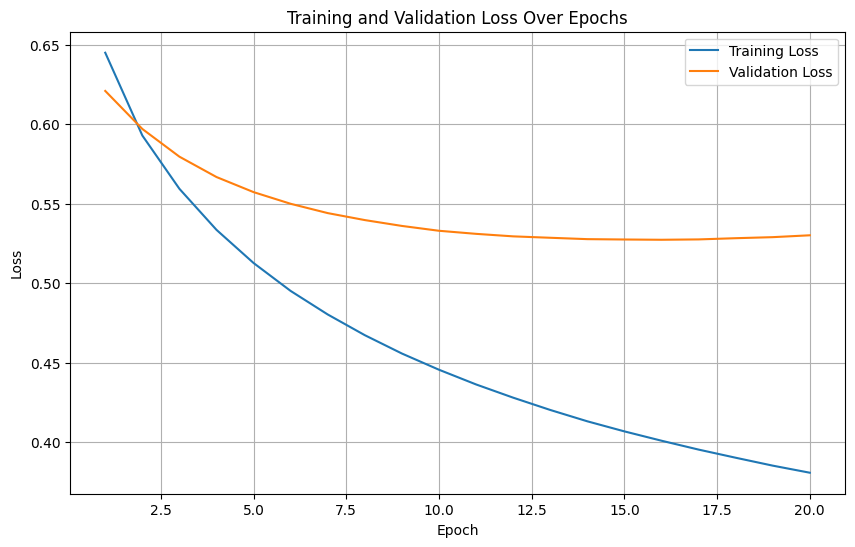

In [35]:
# Train the model
# Try different epoch numbers to find the sweet spot between underfitting and overfitting
training_loop(epoch_number=20)

## Important: Model Reinitialization

> **Critical:** If you want to train the model from scratch multiple times, you **must** reinitialize it. Otherwise, training will continue from where it left off rather than starting fresh with random weights.

To reinitialize the model, rerun these lines:
```python
# Reinitialize model with random weights
model = BoWClassifier(INPUT_DIM, OUTPUT_DIM)

# Reinitialize optimizer (needs to track the new model's parameters)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Reinitialize loss function
criterion = nn.NLLLoss()

# Move to device
model = model.to(device)
criterion = criterion.to(device)
```

Or create a helper function:

In [36]:
def reinitialize(model):
    """Reinitialize model, optimizer, and loss function."""
    # Create new model instance
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.NLLLoss()
    model = model.to(device)
    criterion = criterion.to(device)

In [37]:
reinitialize(BoWClassifier(INPUT_DIM, OUTPUT_DIM))

## 6. Building a Deeper Network

### Adding Hidden Layers

Our current model has only one layer. Let's make it "deep" by adding:
- **Hidden layer:** An intermediate representation between input and output
- **ReLU activation:** A non-linear function that allows the network to learn complex patterns
- **Multiple transformations:** Input → Hidden → Output

**Why add depth?**
- Single layers can only learn linear relationships
- Hidden layers with activations enable learning non-linear patterns
- This often improves performance on complex tasks



Learn more:
- [ReLU activation](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
```

In [38]:
class BoWDeepClassifier(nn.Module):
    def __init__(self, num_labels, vocab_size, hidden_size):
        """Deep Bag-of-Words classifier with one hidden layer."""

        super(BoWDeepClassifier, self).__init__()
        # First layer: transform from vocabulary size to hidden size
        self.linear1 = nn.Linear(vocab_size, hidden_size)
        #Non-linear activation function
        # ReLU(x) = max(0, x) - introduces non-linearity between layers
        # Without this, multiple linear layers would collapse into a single linear transformation
        self.relu = torch.nn.ReLU()
        # Second layer: transform from hidden size to number of classes
        self.linear2 = nn.Linear(hidden_size, num_labels)

    def forward(self, bow_vec, sequence_lens=None):
        """
        Forward pass through the network.

        Args:
            bow_vec: Input Bag-of-Words vectors
            sequence_lens: Not used (kept for compatibility)

        Returns:
            Log probabilities for each class
        """
        output = self.linear1(bow_vec)
        output = self.relu(output)
        output = self.linear2(output)

        # Get the log probabilities
        return nn.functional.log_softmax(output, dim=1)

### Configure Hyperparameters


In [39]:
HIDDEN_SIZE = 200 # Size of the hidden layer - try experimenting with this!
learning_rate = 0.001
BATCH_SIZE = 64
N_EPOCHS = 15

### Initialize and Train

In [40]:
model = BoWDeepClassifier(OUTPUT_DIM, INPUT_DIM, HIDDEN_SIZE) # initialize the model

# Set up optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

# Move to device
model = model.to(device)
criterion = criterion.to(device)

# Display model architecture
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

BoWDeepClassifier(
  (linear1): Linear(in_features=3000, out_features=200, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=200, out_features=2, bias=True)
)
Total parameters: 600602


> **Experiment:** Try different values for `HIDDEN_SIZE` (e.g., 50, 100, 200, 500) and see how it affects performance. Larger hidden sizes can learn more complex patterns but may overfit on small datasets.

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.590 | Train Prec: 21.60% | Train Rec: 48.94% | Train Fscore: 26.98%
	 Val. Loss: 0.534 |  Val Prec: 42.22% | Val Rec: 72.71% | Val Fscore: 52.51%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.424 | Train Prec: 59.34% | Train Rec: 80.20% | Train Fscore: 67.43%
	 Val. Loss: 0.536 |  Val Prec: 54.51% | Val Rec: 68.94% | Val Fscore: 60.19%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.328 | Train Prec: 71.73% | Train Rec: 85.79% | Train Fscore: 77.58%
	 Val. Loss: 0.592 |  Val Prec: 53.22% | Val Rec: 66.07% | Val Fscore: 58.31%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.248 | Train Prec: 80.77% | Train Rec: 89.82% | Train Fscore: 84.69%
	 Val. Loss: 0.659 |  Val Prec: 54.58% | Val Rec: 64.88% | Val Fscore: 58.70%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.184 | Train Prec: 87.30% | Train Rec: 93.86% | Train Fscore: 90.20%
	 Val. Loss: 0.736 |  Val Prec: 55.35% | Val Rec: 61.88% | Val Fscore: 57.79%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.

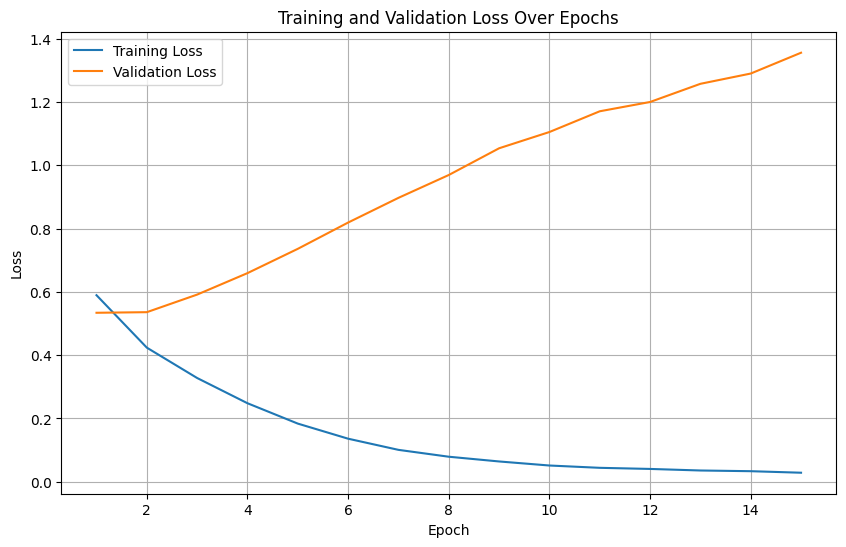

In [41]:
training_loop()

## 7. Early Stopping to Prevent Overfitting

### What is Early Stopping?

Early stopping is a simple but effective technique to prevent overfitting. The idea:
- Monitor validation loss during training
- If validation loss stops improving for several consecutive epochs (while training loss may still decrease), stop training
- This prevents the model from memorizing the training data

**Why it works:** When validation loss stops improving but training loss keeps decreasing, the model is likely starting to overfit to the training data rather than learning generalizable patterns.

### Implementation

We'll implement a patience-based early stopping:
- **Patience:** Number of epochs to wait for improvement before stopping
- If validation loss doesn't improve for `patience` consecutive epochs, training stops automatically
- We save the best model (lowest validation loss) during training

In [42]:
# Reinitialize model for fresh training
model = BoWDeepClassifier(OUTPUT_DIM, INPUT_DIM, HIDDEN_SIZE)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

model = model.to(device)
criterion = criterion.to(device)

In [43]:
def training_loop(epoch_number=15, patience=3):
    """
    Training loop with early stopping.

    Args:
        epoch_number: Maximum number of epochs to train
        patience: Number of epochs to wait for improvement before stopping

    Returns:
        best_valid_loss: Best validation loss achieved during training
    """
    N_EPOCHS = epoch_number
    consecutive_no_improvement = 0

    best_valid_loss = float("inf")  # Initialize with infinity (any loss will be better)

    # Store losses for plotting
    train_losses = []
    valid_losses = []

    # We loop forward on the epoch number
    for epoch in range(N_EPOCHS):

        start_time = time.time()

        # Train and evaluate
        train_loss, train_prec, train_rec, train_fscore = train(
            model, train_iterator, optimizer, criterion
        )

        valid_loss, valid_prec, valid_rec, valid_fscore = evaluate(
            model, valid_iterator, criterion
        )

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Store losses
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Check if validation loss improved
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            consecutive_no_improvement = 0 # Reset counter
            torch.save(model.state_dict(), "bow-deep-model.pt")

        else:
            consecutive_no_improvement += 1 # Increment counter

        # Print epoch results
        print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
        print(
            f"\tTrain Loss: {train_loss:.3f} | Train Prec: {train_prec*100:.2f}% | Train Rec: {train_rec*100:.2f}% | Train Fscore: {train_fscore*100:.2f}%"
        )
        print(
            f"\t Val. Loss: {valid_loss:.3f} |  Val Prec: {valid_prec*100:.2f}% | Val Rec: {valid_rec*100:.2f}% | Val Fscore: {valid_fscore*100:.2f}%"
        )

        # Early stopping check
        if consecutive_no_improvement >= patience:
            print(f"No improvement in validation loss for {patience} consecutive epochs. Early stopping after epoch {epoch+1}.")
            break  # Terminate training loop

    plot_losses(train_losses, valid_losses, n_epochs=epoch+1)

    return best_valid_loss

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.593 | Train Prec: 21.28% | Train Rec: 55.65% | Train Fscore: 26.74%
	 Val. Loss: 0.536 |  Val Prec: 35.98% | Val Rec: 75.58% | Val Fscore: 47.87%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.433 | Train Prec: 57.34% | Train Rec: 79.26% | Train Fscore: 65.42%
	 Val. Loss: 0.529 |  Val Prec: 51.70% | Val Rec: 69.00% | Val Fscore: 58.46%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.331 | Train Prec: 71.83% | Train Rec: 85.61% | Train Fscore: 77.62%
	 Val. Loss: 0.583 |  Val Prec: 54.29% | Val Rec: 64.92% | Val Fscore: 58.53%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.253 | Train Prec: 80.84% | Train Rec: 89.93% | Train Fscore: 84.69%
	 Val. Loss: 0.643 |  Val Prec: 55.23% | Val Rec: 63.93% | Val Fscore: 58.63%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.183 | Train Prec: 87.13% | Train Rec: 93.58% | Train Fscore: 90.01%
	 Val. Loss: 0.718 |  Val Prec: 56.03% | Val Rec: 62.66% | Val Fscore: 58.53%
No improvement in validation loss for 3 conse

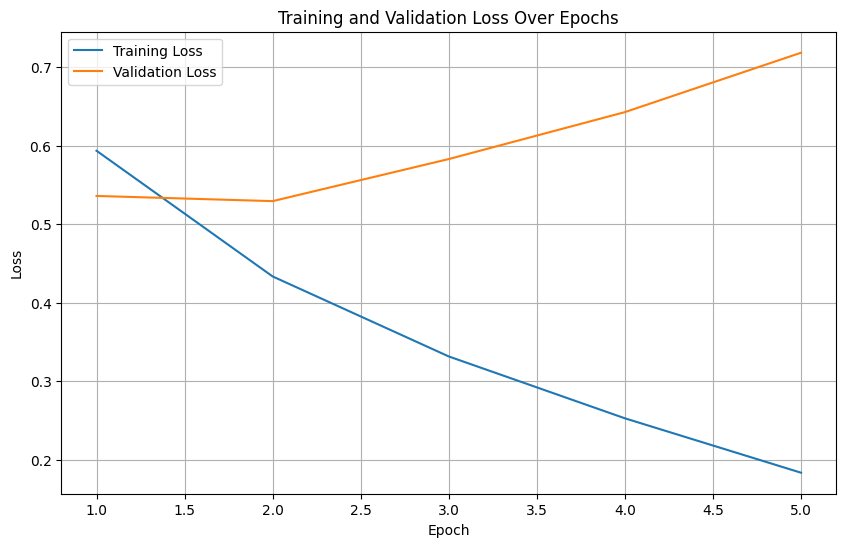

0.5292117914983204

In [44]:
training_loop()

## 8. Handling class imbalance

Our data is imbalanced. The NOT class (0) has roughly twice as many samples as the OFF class (1). This imbalance can bias the model toward predicting the majority class.


In [45]:
tr_data.groupby("label").size()

,0
label,
0,6179
1,3089


### Solution: Weighted Loss Function

We can penalize errors on the minority class more heavily by adding weights to our loss function. The idea is to weight each class by the inverse of its frequency.


In [46]:
# Class 1 (offensive) appears half as often, so weight it twice as much
weights = torch.Tensor([1, 2]).to(device)
criterion = nn.NLLLoss(weight=weights)

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.630 | Train Prec: 60.62% | Train Rec: 50.48% | Train Fscore: 52.83%
	 Val. Loss: 0.586 |  Val Prec: 65.41% | Val Rec: 53.91% | Val Fscore: 58.51%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.455 | Train Prec: 75.61% | Train Rec: 69.74% | Train Fscore: 71.82%
	 Val. Loss: 0.601 |  Val Prec: 69.15% | Val Rec: 55.85% | Val Fscore: 61.20%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.347 | Train Prec: 83.08% | Train Rec: 77.28% | Train Fscore: 79.62%
	 Val. Loss: 0.676 |  Val Prec: 60.31% | Val Rec: 61.60% | Val Fscore: 60.39%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.261 | Train Prec: 88.43% | Train Rec: 84.34% | Train Fscore: 86.01%
	 Val. Loss: 0.760 |  Val Prec: 59.05% | Val Rec: 60.72% | Val Fscore: 59.28%
No improvement in validation loss for 3 consecutive epochs. Early stopping after epoch 4.


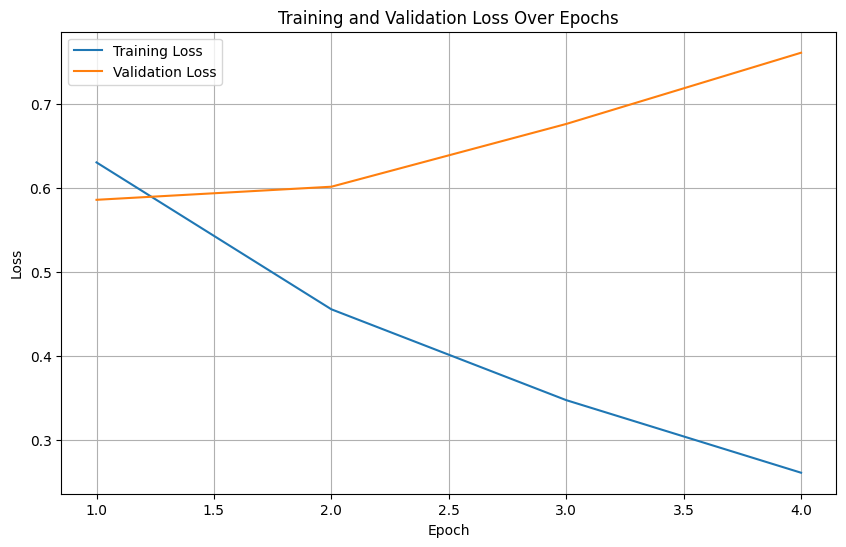

0.5856068938497513

In [47]:
model = BoWDeepClassifier(OUTPUT_DIM, INPUT_DIM, HIDDEN_SIZE)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss(weight=weights)

# Train
training_loop(epoch_number=15, patience=3)

## 9. Adding Embedding Layers

### Why Move Beyond Bag-of-Words?
- So far, we've only used Bag-of-Words representations (size 3000) as features. Limitations:
- **Sparse:** Most values are zero
- **No word relationships:** "good" and "great" are treated as completely different
- **Large dimensionality:** 3000 features for 3000 vocabulary words

### Enter: Word Embeddings
**Key idea:** Represent each word as a dense vector where similar words have similar vectors.

- Words are mapped to continuous vectors (e.g., 100 dimensions instead of 3000)
- The network learns these representations during training
- Semantically similar words end up close together in vector space

We'll use PyTorch's [Embedding layer](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) which learns a dense vector for each word in our vocabulary.

![Embedding architecture](https://pytorch.org/tutorials/_images/text_sentiment_ngrams_model.png)

*Architecture with embedding layer (from pytorch.org)*


### Prepare Data: Convert Text to Token IDs

First, we need to convert words to numerical IDs that the embedding layer can process.

In [48]:
# Get the analyzer from CountVectorizer (handles tokenization, preprocessing, stopword removal)
an = word_to_ix.build_analyzer()

In [49]:
# Example: tokenize and process a sentence
an("What made labubu go viral?❤️")

['make', 'labubu', 'viral?', '❤', '️']

In [50]:
# Our vocabulary maps tokens to IDs
print(f"Vocabulary size: {len(word_to_ix.vocabulary_)}")
print(f"Example mapping: 'hello' -> {word_to_ix.vocabulary_.get('hello', 'not in vocab')}")

Vocabulary size: 3000
Example mapping: 'hello' -> 1259


In [51]:
# Our vocabulary maps tokens to IDs
print(f"Vocabulary size: {len(word_to_ix.vocabulary_)}")
print(f"Example mapping: '✅' -> {word_to_ix.vocabulary_.get('✅', 'not in vocab')}")

Vocabulary size: 3000
Example mapping: '✅' -> 2894


Some tokens end up being not in vocabulary:

In [52]:
# Our vocabulary maps tokens to IDs
print(f"Vocabulary size: {len(word_to_ix.vocabulary_)}")
print(f"Example mapping: 'love' -> {word_to_ix.vocabulary_.get('love', 'not in vocab')}")
print(f"Example mapping: '❤️' -> {word_to_ix.vocabulary_.get('❤️', 'not in vocab')}")

Vocabulary size: 3000
Example mapping: 'love' -> 1606
Example mapping: '❤️' -> not in vocab


One could demojize the text within the text processing step:

In [53]:
emoji.demojize('❤️')

':red_heart:'

In [54]:
def create_input(dataset, analyzer, vocabulary):
    """
    Convert text to sequences of token IDs.

    Args:
        dataset: List of text samples
        analyzer: Tokenizer function from CountVectorizer
        vocabulary: Word-to-ID mapping

    Returns:
        List of tensors, each containing token IDs for one sample

    Special tokens:
        - IDs 0-2999: Vocabulary words
        - ID 3000:  (unknown words not in vocabulary)
        - ID 3001:  (padding, added later)
    """

    dataset_as_indices = []

    for tweet in dataset:
        tokens = analyzer(tweet)
        token_ids = []

        for token in tokens:
            if token in vocabulary:
                token_ids.append(vocabulary[token]) # Known word
            else:
                token_ids.append(3000) # Unknown token

        # If all tokens were removed (stopwords, etc.), add unknown token
        if not token_ids:
            token_ids.append(3000)
        dataset_as_indices.append(torch.LongTensor(token_ids).to(device))

    return dataset_as_indices

In [55]:
# We create the dataset as ids of tokens
dataset_as_ids = create_input(tr_data.tweet, an, word_to_ix.vocabulary_)
dataset_as_ids

[tensor([   1, 1401,  245,   35,  664, 1776,   45], device='cuda:0'),
 tensor([   3, 1606,   45], device='cuda:0'),
 tensor([  0, 979,  27,   0, 768,  45], device='cuda:0'),
 tensor([   1,  126, 1492, 1074, 3000,  245,   28, 2668,   45,  126, 1040, 1592,
           45,   28], device='cuda:0'),
 tensor([   0, 1295, 3000, 1508, 1782, 1814,   27], device='cuda:0'),
 tensor([   0, 2159, 1204,  685,   28, 1803, 1056, 1518, 2175,  124,   28],
        device='cuda:0'),
 tensor([   0,  383, 1906, 1781, 2796, 1552, 1563, 2663, 2726,  328, 2590, 3000,
         1834,  124], device='cuda:0'),
 tensor([   3, 2700, 2596,   54,  671, 2231,  265, 1552, 3000, 2445, 1861, 1260,
         1552,   45, 1909, 3000, 1943, 3000,    0, 2016, 1260,  657,   33,  230,
          121, 3000, 2016,   45], device='cuda:0'),
 tensor([   0, 1552, 3000,   29, 3000], device='cuda:0'),
 tensor([  29, 2750, 1552,   50, 1889, 3000,   45, 2698], device='cuda:0'),
 tensor([   0, 2014, 1160, 1958,  126, 2883, 1249, 1593,   47, 2

In [56]:
# Example: view token IDs for a sample
print(f"Sample tweet: '{tr_data.iloc[90]['tweet']}'")
print(f"Token IDs: {dataset_as_ids[90]}")

Sample tweet: '  Free Speech Systems LLC' aka 'InfoWars' is linked to a Foreign Intel Agency or other Non_Domestic entity?'
Token IDs: tensor([   1, 1102, 2426, 3000, 3000,   34,  209,   34, 3000,   34, 1568, 1088,
        1385,  197, 3000, 3000,  124], device='cuda:0')


## 10. Padding Sequences

**Problem:** Neural networks expect fixed-size inputs, but tweets have different lengths.

**Solution:** Pad shorter sequences with a special `<PAD>` token (ID 3001) to make all sequences the same length.

![Padding visualization](https://miro.medium.com/max/1218/1*zsIXWoN0_CE9PXzmY3tIjQ.png)
*Padding sequences to uniform length (image from towardsdatascience.com)*

In [57]:
tr_data.tweet.str.len()

,tweet
1224,59
9102,14
3655,28
8201,92
6141,62
...,...
11468,63
7221,275
1318,52
8915,50


In [58]:
# Sort data by length (groups similar-length sequences together for efficiency)
tr_data = tr_data.assign(length=tr_data.tweet.str.len()).sort_values(by='length')
val_data = val_data.assign(length=val_data.tweet.str.len()).sort_values(by='length')

In [59]:
val_data

,id,tweet,subtask_a,subtask_b,subtask_c,label,length
8166,37849,Bull,NOT,NaN,NaN,0,5
10467,26126,Good,NOT,NaN,NaN,0,5
658,73253,Sexy,NOT,NaN,NaN,0,5
396,23159,Ouch!,OFF,UNT,NaN,1,6
738,90997,Sucks,OFF,TIN,IND,1,6
...,...,...,...,...,...,...,...
582,33099,You are suggesting that it i...,NOT,NaN,NaN,0,297
6677,83999,...,NOT,NaN,NaN,0,297
10311,82164,It is always same-trash Trump &amp; conservat...,OFF,TIN,GRP,1,300
1994,67217,My Dad didn’t die so ANYONE could disres...,NOT,NaN,NaN,0,301


In [60]:
from torch.nn.utils.rnn import pad_sequence

# Example: pad a list of sequences
sample_sequences = [
    torch.tensor([1, 2, 3]),
    torch.tensor([4, 5]),
    torch.tensor([6, 7, 8, 9])
]
padded = pad_sequence(sample_sequences, batch_first=True, padding_value=3001)
print(f"Original sequences:\n{sample_sequences}")
print(f"\nPadded sequences (batch_first=True):\n{padded}")
print(f"Shape: {padded.shape}  # [num_sequences, max_length]")

Original sequences:
[tensor([1, 2, 3]), tensor([4, 5]), tensor([6, 7, 8, 9])]

Padded sequences (batch_first=True):
tensor([[   1,    2,    3, 3001],
        [   4,    5, 3001, 3001],
        [   6,    7,    8,    9]])
Shape: torch.Size([3, 4])  # [num_sequences, max_length]


`torch.nn.utils.rnn.pad_sequence` takes a list of tensors as input (sequences), calculates max length, and then pads all the sequences with `padding_value` to make them all have the same length

Here you can see the dimension of `padded`, so max length among the sequences is 86.

In [61]:
def prepare_dataloader_with_padding(tr_data, val_data, word_to_ix):
    """
    Convert text to padded token ID sequences and create data loaders.

    Returns tuples of (padded_sequences, labels, original_lengths, raw_texts)
    """

    tr_data_vecs = pad_sequence(
        create_input(tr_data.tweet, an, word_to_ix.vocabulary_),
        batch_first=True, # Shape: [batch_size, max_length]
        padding_value=3001,
    )
    tr_labels = torch.LongTensor(tr_data.label.tolist()).to(device)
    tr_lens = torch.LongTensor(
        [len(i) for i in create_input(tr_data.tweet, an, word_to_ix.vocabulary_)] #len of tweets
    )
    # Print information about sequence lengths (stored BEFORE padding for pack_padded_sequence)
    print(f"\nTraining sequences: {tr_data_vecs.shape[0]} samples padded to max length {tr_data_vecs.shape[1]}")
    print(f"Original lengths (before padding): min={tr_lens.min()}, max={tr_lens.max()}, mean={tr_lens.float().mean():.1f}")
    #print(f"Lengths tensor shape: {tr_lens.shape}")

    # We also add the texts to the batches
    # This is for the Transformer models, you won't need this in the next experiments
    tr_raw_texts = tr_data.tweet.tolist()

    val_data_vecs = pad_sequence(
        create_input(val_data.tweet, an, word_to_ix.vocabulary_),
        batch_first=True,
        padding_value=3001,
    )
    val_labels = torch.LongTensor(val_data.label.tolist()).to(device)
    val_lens = torch.LongTensor(
        [len(i) for i in create_input(val_data.tweet, an, word_to_ix.vocabulary_)]
    )

    val_raw_texts = val_data.tweet.tolist()

    # Create data loaders with 4 elements per sample
    tr_data_loader = [
        (sample, label, length, sent)
        for sample, label, length, sent in zip(
            tr_data_vecs, tr_labels, tr_lens, tr_raw_texts
        )
    ]
    val_data_loader = [
        (sample, label, length, sent)
        for sample, label, length, sent in zip(
            val_data_vecs, val_labels, val_lens, val_raw_texts
        )
    ]

    return tr_data_loader, val_data_loader

In [62]:
# Prepare padded data
tr_data_loader, val_data_loader = prepare_dataloader_with_padding(
    tr_data, val_data, word_to_ix
)


Training sequences: 9268 samples padded to max length 86
Original lengths (before padding): min=1, max=86, mean=14.4


In [63]:
def create_dataloader_iterators_with_padding(
    tr_data_loader, val_data_loader, BATCH_SIZE
):
    train_iterator = DataLoader(
        tr_data_loader,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )

    valid_iterator = DataLoader(
        val_data_loader,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    return train_iterator, valid_iterator

In [64]:
# Create DataLoader iterators
train_iterator, valid_iterator = create_dataloader_iterators_with_padding(
    tr_data_loader, val_data_loader, BATCH_SIZE
)

**Inspect a batch:**

In [65]:
padded_samples, labels, orig_lengths, raw_texts = next(iter(train_iterator))
print(f'Dimension of tensors with data samples (BATCH_SIZE, max_sequence_length): {padded_samples.shape}')
print(f'Number of tweets in batch: {len(raw_texts)}')
print(f'\nExample (2nd sample in batch):')
print(f'  Token IDs (padded): {padded_samples[1]}')
print(f'  Original length: {orig_lengths[1]} tokens')
print(f"  Label: {labels[1].item()} ({'OFF' if labels[1].item() == 1 else 'NOT'})")
print(f'  Raw text: "{raw_texts[1]}"')

Dimension of tensors with data samples (BATCH_SIZE, max_sequence_length): torch.Size([64, 86])
Number of tweets in batch: 64

Example (2nd sample in batch):
  Token IDs (padded): tensor([   0, 3000, 1109, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001,
        3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001,
        3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001,
        3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001,
        3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001,
        3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001,
        3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001, 3001,
        3001, 3001], device='cuda:0')
  Original length: 3 tokens
  Label: 1 (OFF)
  Raw text: " HPLYK FUCK"


## 11. Building the Embedding-Based Model

### Architecture

![Embedding + Pooling architecture](https://github.com/bentrevett/pytorch-sentiment-analysis/raw/b4efbefa47672174394a8b6a27d4e7bc193bc224/assets/sentiment8.png)

*Bag-of-Words model with embedding layer and max pooling (from bentrevett)*

**How it works:**
1. **Embedding layer:** Maps each token ID to a dense vector
2. **Max pooling:** Reduces the sequence of word embeddings to a single vector by taking the maximum value across each dimension
3. **Linear layer:** Maps the pooled vector to class scores

**Max pooling example:**
```
Word embeddings:
  "I"    → [0.1, 0.3, 0.2]
  "hate" → [0.5, 0.7, 0.6]
  "this" → [0.2, 0.1, 0.3]
  "film" → [0.4, 0.9, 0.8]

Max pooling (take max of each column):
  Result → [0.5, 0.9, 0.8]  ← This represents the entire tweet

In [66]:
from torch import nn
import numpy as np


class BoWClassifierWithEmbedding(nn.Module):
    """Bag-of-Words classifier using learned embeddings and max pooling."""
    def __init__(self, num_labels, vocab_size, embedding_dim):
        super(BoWClassifierWithEmbedding, self).__init__()

        # Embedding layer: maps token IDs to dense vectors
        # vocab_size: total number of words (including  and )
        # embedding_dim: size of each word vector
        # padding_idx: ID for padding token (always maps to zeros, not trained)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=3001)
        # Enable training of embeddings (can be set to False to use pre-trained embeddings)
        self.embedding.weight.requires_grad = True
        # Linear layer: maps pooled embedding to class scores
        self.linear = nn.Linear(embedding_dim, num_labels)

    def forward(self, text, sequence_lens):
        """
        Forward pass.

        Args:
            text: Token IDs [batch_size, seq_len]
            sequence_lens: Original sequence lengths (not used here)

        Returns:
            Log probabilities [batch_size, num_labels]
        """
        # Convert token IDs to embeddings
        # Shape: [batch_size, seq_len] → [batch_size, seq_len, embedding_dim]
        embedded = self.embedding(text)
        # Max pooling: reduce sequence to single vector
        # For each of the embedding_dim dimensions, take the max value across all words
        # kernel_size=(seq_len, 1) means: max over all words, separately for each embedding dimension
        # Shape: [batch_size, seq_len, embedding_dim] → [batch_size, embedding_dim]
        pooled = nn.functional.max_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1)  # dim=64x100 (batch_size x embedding_dim)
        # Pass through linear layer and apply log_softmax
        return nn.functional.log_softmax(self.linear(pooled), dim=1)

In [67]:
# Initialize model
INPUT_DIM = VOCAB_SIZE + 2  # 3002
OUTPUT_DIM = 2
EMBEDDING_DIM = 100  # Each word represented as a 100-dimensional vector
HIDDEN_DIM = 20
criterion = nn.NLLLoss()

model = BoWClassifierWithEmbedding(OUTPUT_DIM, INPUT_DIM, EMBEDDING_DIM)
model = model.to(device)

In [68]:
# Set up training
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss()
criterion = criterion.to(device)

print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Embedding parameters: {model.embedding.weight.numel()}")

BoWClassifierWithEmbedding(
  (embedding): Embedding(3002, 100, padding_idx=3001)
  (linear): Linear(in_features=100, out_features=2, bias=True)
)
Total parameters: 300402
Embedding parameters: 300200


Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.655 | Train Prec: 7.28% | Train Rec: 31.12% | Train Fscore: 10.73%
	 Val. Loss: 0.649 |  Val Prec: 0.88% | Val Rec: 8.60% | Val Fscore: 1.52%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.623 | Train Prec: 8.14% | Train Rec: 40.64% | Train Fscore: 12.56%
	 Val. Loss: 0.623 |  Val Prec: 11.75% | Val Rec: 46.17% | Val Fscore: 18.06%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.602 | Train Prec: 11.76% | Train Rec: 57.38% | Train Fscore: 18.12%
	 Val. Loss: 0.608 |  Val Prec: 16.82% | Val Rec: 56.24% | Val Fscore: 25.10%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.578 | Train Prec: 19.66% | Train Rec: 68.68% | Train Fscore: 29.08%
	 Val. Loss: 0.597 |  Val Prec: 12.00% | Val Rec: 63.84% | Val Fscore: 19.55%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.555 | Train Prec: 27.11% | Train Rec: 73.26% | Train Fscore: 37.54%
	 Val. Loss: 0.587 |  Val Prec: 33.29% | Val Rec: 60.79% | Val Fscore: 41.98%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.531 |

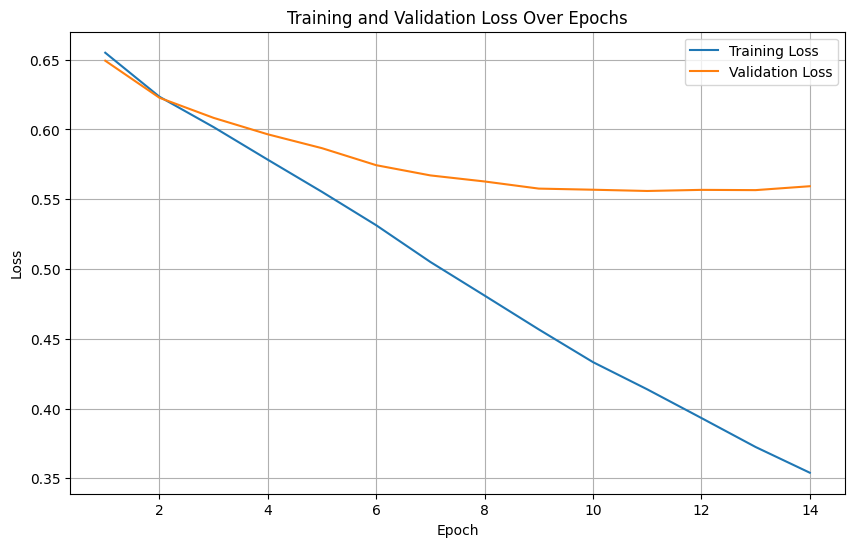

0.555943480086705

In [69]:
### Train the Model
training_loop(epoch_number=15)

> **Note:** The embedding layer adds many parameters (vocab_size × embedding_dim = 3002 × 100 = 300,200). This gives the model more capacity to learn, but also increases the risk of overfitting on small datasets. Watch the validation loss carefully!

***Optional: Using Pre-trained Embeddings***

Instead of learning embeddings from scratch, you can load pre-trained embeddings like GloVe or Word2Vec.

## 12. Standard RNNs & LSTMs

### Why Sequential Models?

So far, our models have ignored word order:
- **Bag-of-Words:** Treats "I love this movie" and "This movie I love" identically
- **Max pooling:** Takes the maximum embedding value, losing sequence information

**RNNs process text sequentially**, maintaining a hidden state that captures information from previous words. This allows them to understand context and word order.

### Understanding RNNs

An RNN processes one word at a time, updating its hidden state at each step:

![Unrolled RNN](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)
*Unrolled RNN showing sequential processing (from [colah's blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/))*

**Standard RNN module:**

![RNN module](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png)
*A single RNN cell applies a simple transformation (from [colah's blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/))*

**Problem with standard RNNs:** They struggle to learn long-term dependencies due to vanishing/exploding gradients.

### Long Short-Term Memory (LSTM)

LSTMs solve the long-term dependency problem using a more sophisticated cell structure with gates that control information flow:

![LSTM module](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)
*LSTM cell with gates for controlling information (from [colah's blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/))*

**LSTM outputs:**

![LSTM outputs](https://i.stack.imgur.com/SjnTl.png)

*LSTM produces hidden states (h) and cell states (c) at each time step (from stackoverflow)*


In [70]:
class LSTMClassifier(nn.Module):
    """
    Text classifier using LSTM for sequential processing.

    Architecture: Embeddings → LSTM → Linear → Output
    The LSTM processes the sequence and we use its final hidden state for classification.
    """
    def __init__(self, num_labels, vocab_size, embedding_dim, hidden_dim):
        super(LSTMClassifier, self).__init__()
        # Embedding layer (same as before)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=3001)
        self.embedding.weight.requires_grad = True

        # LSTM layer
        # Takes sequence of embeddings, outputs sequence of hidden states
        # Documentation: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        self.lstm = nn.LSTM(
            embedding_dim,          # Size of input embeddings
            hidden_dim,             # Size of hidden state
            batch_first=True,       # Input shape: [batch, seq_len, features]
            num_layers=1,           # Single LSTM layer
            bidirectional=False,    # Process sequence left-to-right only
        )
        # Classification layer (uses final LSTM hidden state)
        self.linear = nn.Linear(hidden_dim, num_labels)
        # Dropout for regularization to overcome overfitting
        self.dropout = nn.Dropout(0.25)

    def forward(self, text, sequence_lens):
        """
        Forward pass.

        Args:
            text: Padded token IDs [batch_size, max_seq_len]
            sequence_lens: Original sequence lengths (before padding)

        Returns:
            Log probabilities [batch_size, num_labels]
        """
        # Convert token IDs to embeddings
        # Shape: [batch_size, seq_len, embedding_dim]
        embedded = self.embedding(text)

        # Pack padded sequences to avoid computing LSTM on padding tokens
        # This is more efficient and prevents the LSTM from learning patterns in padding
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded,
            sequence_lens,
            enforce_sorted=False,   # Don't require sequences sorted by length
            batch_first=True
        )
        # Pass through LSTM
        # packed_outputs: all hidden states (one per time step)
        # h: final hidden state [num_layers, batch_size, hidden_dim]
        # c: final cell state (not used for classification)
        packed_outputs, (h, c) = self.lstm(packed)
        # Unpack the outputs (converts back to padded format)
        # We don't actually use lstm_outputs here, but this shows how to extract them
        lstm_outputs, lens = nn.utils.rnn.pad_packed_sequence(
            packed_outputs, batch_first=True
        )

        # Use the final hidden state for classification
        # h[-1] selects the last layer's hidden state
        # Shape: [batch_size, hidden_dim]
        final_hidden = h[-1]

        # Apply dropout and linear transformation
        output = self.linear(self.dropout(final_hidden))

        # Convert to log probabilities
        return nn.functional.log_softmax(output, dim=1)

### Train the LSTM Model

In [71]:
INPUT_DIM = VOCAB_SIZE + 2  # 3000 +  +
OUTPUT_DIM = 2
EMBEDDING_DIM = 100
HIDDEN_DIM = 20  # Size of LSTM hidden state

# Initialize model
model = LSTMClassifier(OUTPUT_DIM, INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM)
model = model.to(device)

In [72]:
# Set up training
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss()
criterion = criterion.to(device)

print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

LSTMClassifier(
  (embedding): Embedding(3002, 100, padding_idx=3001)
  (lstm): LSTM(100, 20, batch_first=True)
  (linear): Linear(in_features=20, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
Total parameters: 310002


Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 0.646 | Train Prec: 7.45% | Train Rec: 32.34% | Train Fscore: 9.96%
	 Val. Loss: 0.628 |  Val Prec: 2.39% | Val Rec: 38.10% | Val Fscore: 4.39%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 0.621 | Train Prec: 4.07% | Train Rec: 45.80% | Train Fscore: 7.32%
	 Val. Loss: 0.617 |  Val Prec: 4.30% | Val Rec: 42.33% | Val Fscore: 7.54%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.592 | Train Prec: 14.28% | Train Rec: 69.70% | Train Fscore: 22.36%
	 Val. Loss: 0.597 |  Val Prec: 18.36% | Val Rec: 58.55% | Val Fscore: 27.22%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.542 | Train Prec: 34.72% | Train Rec: 73.22% | Train Fscore: 45.53%
	 Val. Loss: 0.590 |  Val Prec: 37.59% | Val Rec: 56.07% | Val Fscore: 44.22%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.486 | Train Prec: 49.69% | Train Rec: 74.99% | Train Fscore: 58.86%
	 Val. Loss: 0.584 |  Val Prec: 39.08% | Val Rec: 59.78% | Val Fscore: 46.45%
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 0.432 | Tr

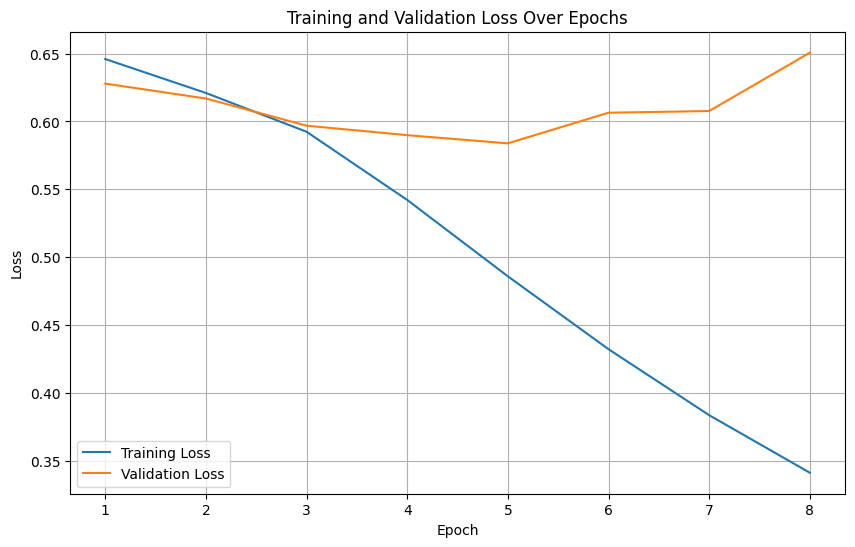

0.5838835565816789

In [73]:
training_loop(epoch_number=15)

### Understanding pack_padded_sequence

**Why pack sequences?**
- Padded tokens (ID 3001) don't contain useful information
- Without packing, the LSTM would waste computation on padding
- Packing tells the LSTM where each sequence actually ends

### Further Reading: Advanced LSTMs

Interested in the latest LSTM developments? Check out:

**[xLSTM: Extended Long Short-Term Memory](https://arxiv.org/abs/2405.04517)** by Sepp Hochreiter's group (2024)

Key innovations:
- **Exponential gating:** Improved information flow control
- **New memory structures:** Better handling of long-term dependencies
- **mLSTM variant:** Addresses parallelization limitations of traditional LSTMs

## 13. Transformers

### Why Transformers? Problems with RNNs

Recall that we used LSTMs to encode sequences into vectors. While effective, RNNs have fundamental limitations:

**Problem 1: No Parallelism**
- LSTMs process tokens sequentially (left-to-right), requiring previous steps to complete before processing the next token
- Cannot parallelize computation across the sequence

**Problem 2: Long-Range Dependencies**
- Despite improvements over vanilla RNNs, LSTMs still struggle with very long-range dependencies
- Example: "The people who called and wanted to rent your house when you go away next year are from California"
- Too many backpropagation steps between distant related words

![Encoder-Decoder RNN](https://miro.medium.com/v2/resize:fit:720/format:webp/1*1JcHGUU7rFgtXC_mydUA_Q.jpeg)

*Traditional seq2seq without attention (from [medium](https://towardsdatascience.com/understanding-encoder-decoder-sequence-to-sequence-model-679e04af4346))*

### The Solution: Attention Mechanism

The attention mechanism, introduced in 2014 ([Bahdanau et al.](https://arxiv.org/abs/1409.0473)), revolutionized NLP by allowing models to focus on relevant parts of the input when making predictions.

![Encoder-Decoder with Attention](https://miro.medium.com/v2/resize:fit:640/format:webp/1*KrCUK30Y1R7TV7xE-ltcpg.png)
*Seq2seq with attention mechanism (from [medium](https://medium.com/data-science-community-srm/understanding-encoders-decoders-with-attention-based-mechanism-c1eb7164c581))*

**Key innovation:** Instead of compressing the entire input into a single vector, attention allows the model to look back at all input tokens when making predictions.

### Transformers: "Attention Is All You Need"

The [Transformer architecture](https://arxiv.org/abs/1706.03762) (Vaswani et al., 2017) eliminates recurrence entirely, relying solely on attention mechanisms.

![Transformer Architecture](https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png)
*Transformer architecture (from [machinelearningmastery.com](https://machinelearningmastery.com))*
**Key features:**
- **Self-attention:** Each word attends to all other words in the sequence
- **Parallel processing:** No sequential dependencies, can process entire sequence at once
- **Multi-headed attention:** Multiple attention mechanisms running in parallel

**Self-attention example:**
"The animal didn't cross the street because **it** was too tired"
- Self-attention learns to associate "it" with "animal"

![Self-attention mechanism](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*maneqIvralwRZWf0g3hS5w.png)
*Self-attention visualization (from [towardsdatascience](https://towardsdatascience.com/all-you-need-to-know-about-attention-and-transformers-in-depth-understanding-part-1-552f0b41d021))*

**Learn more:** [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/) by Jay Alammar

### BERT: Bidirectional Encoder Representations from Transformers

[BERT](https://www.aclweb.org/anthology/N19-1423/) (Devlin et al., 2018) is a pre-trained transformer model that revolutionized NLP by enabling transfer learning.

**Pre-training objectives:**
1. **Masked Language Model (MLM):** Predict randomly masked words
   - 15% of tokens are masked: 80% replaced with [MASK], 10% random token, 10% unchanged
2. **Next Sentence Prediction (NSP):** Predict if two sentences are consecutive

**Training scale:**
- BERT-base: 110M parameters, trained on BookCorpus + English Wikipedia
- Vocabulary size: 30,522 WordPiece tokens

**Fine-tuning approach:**
1. Load pre-trained BERT model
2. Add task-specific classification layer on top
3. Fine-tune on your labeled dataset (much smaller than pre-training data)
4. Option: Freeze BERT weights and train only classification layer

![BERT fine-tuning](https://production-media.paperswithcode.com/methods/new_BERT_Overall.jpg)
*BERT fine-tuning for different tasks*

### WordPiece Tokenization

BERT uses its own tokenizer - **always tokenize with BERT's tokenizer, not your custom preprocessing!**

**Special tokens:**
- `[CLS]`: Classification token (start of sequence)
- `[SEP]`: Separator token (end of sequence)
- `[MASK]`: Masked token (for pre-training)
- `[UNK]`: Unknown token
- `[PAD]`: Padding token (ID 0)

**How it works:** Subword tokenization between character and word level
- Frequent words: kept whole
- Rare words: split into subwords
- Unknown characters: handled gracefully

In [74]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Example tokenization
text = "I love Python 🐍 and data analysis 📊 ❤️!"
tokens = tokenizer.tokenize(text)
print(f"Tokens: {tokens}")

# Check vocabulary size
print(f"Vocabulary size: {len(tokenizer.get_vocab())}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokens: ['i', 'love', 'python', '[UNK]', 'and', 'data', 'analysis', '[UNK]', '[UNK]', '!']
Vocabulary size: 30522


In [75]:
# Example: complex name tokenization
tokens = tokenizer.tokenize("His full name is Fyodor Mikhailovich Dostoevsky")
print(f"Name tokens: {tokens}")

Name tokens: ['his', 'full', 'name', 'is', 'f', '##yo', '##dor', 'mikhail', '##ovich', 'dos', '##to', '##evsky']


**Tokenize two sentences:**

In [76]:
# Format: [CLS] Sentence 1 [SEP] Sentence 2 [SEP]
encoded = tokenizer("There are black cats and black dogs.", "Another sentence.")
print(encoded)

{'input_ids': [101, 2045, 2024, 2304, 8870, 1998, 2304, 6077, 1012, 102, 2178, 6251, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


=> [CLS] Sentence 1 [SEP] Sentence 2 [SEP]

100: [UNK] (Unknown token)

101: [CLS] (Classification Token)

102: [SEP] (Separator Token): The [CLS] token is special in BERT as it is used to aggregate information from the entire sequence. Its output embedding (from the last layer of the model) is often used for classification tasks (e.g., sentiment analysis, sentence-pair classification).

103: [MASK] (Masked Token)

0: [PAD] (Padding)


**Now, let's have a look at how another tokeniser works:**

In [77]:
from transformers import BertTokenizer

# BERTweet (trained on tweets)
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
text = "I love Python 🐍 and data analysis 📊!"

# Tokenize the text
tokens = tokenizer.tokenize(text)
print(tokens)

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

['I', 'love', 'Python', '🐍', 'and', 'data', 'analysis', '📊@@', '!']


### Fine-tuning BERT on Our Dataset with HuggingFace

**Prepare data:**

In [78]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Convert dataframes to lists
train_texts = tr_data.tweet.tolist()
train_labels = tr_data.label.tolist()
val_texts = val_data.tweet.tolist()
val_labels = val_data.label.tolist()

In [79]:
# Tokenize all at once
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

**Create PyTorch Dataset:**

In [80]:
class TweetDataset(torch.utils.data.Dataset):
    """Custom dataset for BERT fine-tuning."""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)

**Define metrics:**

In [81]:
def compute_metrics(pred):
    """Compute metrics for evaluation."""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', pos_label=1
    )
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

**Train with Weights & Biases tracking:**


In [82]:
# Initialize W&B
current_date = datetime.now().strftime("%Y%m%d")
wandb.init(project="bert-finetuning", name=f"bert-base-uncased-semeval-{current_date}")


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: varvara-arzt (kleines-gespeist) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [83]:
# Training configuration
training_args = TrainingArguments(
    output_dir=f"./results_bert_{current_date}",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir=f"./logs_bert_{current_date}",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    report_to="wandb"
)

In [84]:
# Initialize model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train
trainer.train()

# Final evaluation
results = trainer.evaluate()
print(f"\nFinal results: {results}")
wandb.log(results)

# Save model
trainer.save_model(f"./saved_model_bert_{current_date}")

# Finish W&B run
wandb.finish()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.342300,0.575008,0.789527,0.683812,0.678170,0.689550
2,0.283100,0.578544,0.783233,0.692610,0.651007,0.739893
3,0.340300,0.739971,0.790785,0.648328,0.728137,0.584287
4,0.300300,1.106781,0.781219,0.669958,0.667171,0.672769



Final results: {'eval_loss': 0.5750077962875366, 'eval_accuracy': 0.7895266868076536, 'eval_f1': 0.6838124054462935, 'eval_precision': 0.6781695423855963, 'eval_recall': 0.6895499618611747, 'eval_runtime': 24.431, 'eval_samples_per_second': 162.581, 'eval_steps_per_second': 20.343, 'epoch': 4.0}


epoch,▁
eval/accuracy,▇▂█▁▇
eval/f1,▇█▁▄▇
eval/loss,▁▁▃█▁
eval/precision,▃▁█▂▃
eval/recall,▆█▁▅▆
eval/runtime,▁▇▇▅█
eval/samples_per_second,█▂▂▃▁
eval/steps_per_second,█▂▂▃▁
eval_accuracy,▁
+12,...
